# **TP2 - CRÍTICAS CINEMATOGRÁFICAS - Blue Squad - Notebook XGBoost**

Integrantes:
- Franco Ricciardo Calderaro
- Matias Agustin Ferrero Cipolla
- Carlos Orqueda
- Sebastian Kraglievich


## Imports

In [ ]:
%pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=dc16b42af93c147160576416a1100279966bdc93f8e05ca9e2092c07ebdf7d8f
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
# Manipulacion y Visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from collections import Counter
import joblib

#Libreria Procesamiento de Lenguaje Natural
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import scipy.stats as st
import langid

#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#XGBoost
import xgboost as xgb

#modelos y métricas
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, precision_recall_curve, roc_auc_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [ ]:
criticas = pd.read_csv('./train.csv')
kaggle_test = pd.read_csv('./test.csv')

## Preprocesamiento

Arrancamos analizando el dataframe para identificar posibles datos faltantes.

In [ ]:
criticas.isna().sum()

ID             0
review_es      0
sentimiento    0
dtype: int64

Analizando la columna *sentimiento*, observamos que la variable toma dos valores: positivo y negativo.

Ademas podemos ver que se ambos valores son el 50% de la variable.

In [ ]:
criticas['sentimiento'].value_counts()

sentimiento
positivo    25000
negativo    25000
Name: count, dtype: int64

Para poder entrenar los modelos, modificamos la variable *sentimiento* para que tenga valores {Negativo = 0, Positivo = 1 }.

In [ ]:
criticas.replace(to_replace = {'negativo' : 0, 'positivo' : 1}, inplace = True)

Para asegurar que solo tengamos criticas en español, creamos una funcion que detecte el idioma en el que estan escritas y se la aplicamos a todas las filas del dataframe.

In [ ]:
def detect_language(text):
    return langid.classify(text)[0]

In [ ]:
criticas['language'] = criticas['review_es'].apply(detect_language)
criticas_spanish = criticas[criticas['language'] == 'es']
criticas_spanish.shape

(48179, 4)

Obtenemos una diferencia de 1821 criticas que son de otros idiomas, y eliminamos para quedarnos solo con las reseñas en español.

In [ ]:
criticas_spanish = criticas_spanish.drop(columns=['language'])
criticas = criticas_spanish.copy()

A continuacion, creamos una lista de la frecuencia de cada palabra en nuestro dataframe. Gracias a esto podemos identificar las palabras mas comunes y decidir cuales podemos filtrar para reducir la cantidad de variables en nuestro analisis.

Despuas de calcular la frecuencia de las palabras, evaluamos cuales pueden ser eliminadas. Las palabras mas frecuentes podrian ser consideradas como stopwords, mientras que las poco frecuentes podrian ser terminos irrelevantes.

Este proceso simplifica nuestro dataframe, y nos permite centrarnos en las palabras mas relevantes, facilitando la interpretacion de los resultados finales.

In [ ]:
# Combine all reviews into a single string
all_reviews = ' '.join(criticas['review_es'])
all_reviews = all_reviews.lower()

# Split the combined text into words using spaces, commas, and periods as delimiters
words = re.split(r'[\s,.()!?¿¡0123456789#$:;+*%&/={}"]', all_reviews)

# Remove empty strings resulting from splitting
words = [word for word in words if word]

# Count the frequency of each word using Counter
word_counts = Counter(words)

# Convert word_counts to a DataFrame
word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['palabra', 'frecuencia'])
word_counts_df = word_counts_df.sort_values(by='frecuencia', ascending=False)

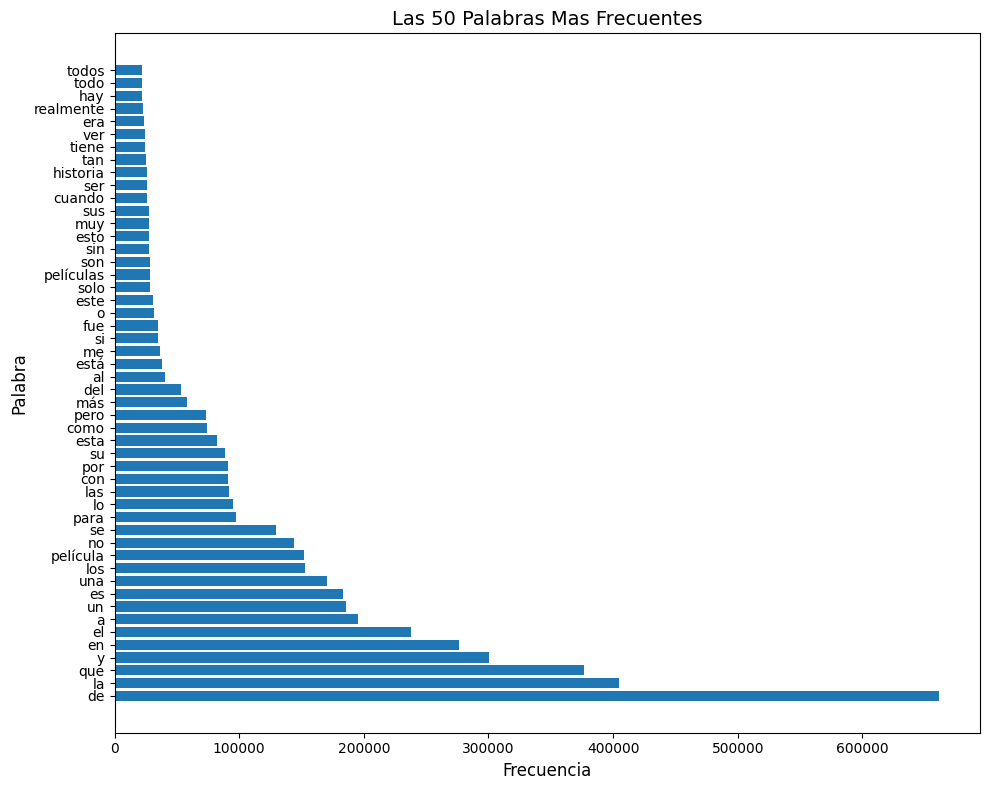

In [ ]:
plt.figure(figsize = (10, 8))
plt.barh(word_counts_df['palabra'][:50], word_counts_df['frecuencia'][:50])

plt.ylabel('Palabra', fontsize = 12)
plt.xlabel('Frecuencia', fontsize = 12)
plt.title('Las 50 Palabras Mas Frecuentes', fontsize = 14)
plt.yticks(fontsize = 10)

plt.tight_layout()
plt.show()

Observamos una marcada presencia de palabras repetidas, principalmente palabras funcionales (articulos, conjunciones, preposiciones), mientras que las palabras que no son consideradas palabras funcionales muestran una frecuencia más uniforme. Para mejorar el análisis, eliminamos las palabras funcionales identificadas hasta ahora, ya que no aportan informacion relevante.

También eliminamos numerosas palabras con una frecuencia igual a 1 que suelen ser inexistentes o no están relacionadas con el análisis de sentimientos, por lo que, tambien decidimos descartarlas del analisis.

### NLTK

Con NLTK (Natural Language Toolkit), preparamos nuestro dataset con procesos de preprocesamiento, simplificando nuestras variables para un análisis más efectivo. Para esto, realizamos:

*   __Tokenización__
*   __Eliminación de stopwords:__
*   __Lemmatization:__

In [ ]:
lemmatizer = WordNetLemmatizer()  # No hay lematizador específico en NLTK para español, pero usaremos uno general
stop_words = set(stopwords.words('spanish'))

def preprocesar_texto_lemm(texto):

    # Reemplazar signos de puntuación por un espacio
    texto = re.sub(r'[^\w\s]', ' ', texto)

    # Eliminar cualquier secuencia de más de un espacio
    texto = re.sub(r'\s+', ' ', texto).strip()

    # Tokenizacion
    tokens = word_tokenize(texto.lower())

    # quitar stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lematización
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return ' '.join(tokens_lemmatized)

Tambien, probamos utilizar varios Regex, como por ejemplo, para eliminar caracteres especiales, diacriticos, signos de puntuacion, convertir todas las palabras a minisculas, etc. Sin embargo, los mejores resultados en Kaggle se alcanzaron con el `preprocesar_texto_lemm` con NTLK, y 2 simples regex. Cuanto mas simple sea el análisis; mejor!

In [ ]:
criticas_filtradas = criticas.copy()
criticas_filtradas['processed_review'] = criticas_filtradas['review_es'].apply(preprocesar_texto_lemm)

Como tenemos datos categóricos y nuestros modelos necesitan datos numéricos, vamos a utilizar un modelo para convertir palabras a vectores de números.

Y para poder mejorar el rendimiento en la competencia de kaggle, utilizamos el vocabulario del archivo de test.

Vamos a calcular las matrices de ocurrencias de términos usando sklearn.

Ambas clases primero construyen el vocabulario total, y luego:
- **TF-IDF**: calcula la frecuencia de cada termino por documento, y normaliza por el total de documentos donde el termino aparece.

In [ ]:
vectorizer_test = TfidfVectorizer(min_df = 3)
tfidf_test = vectorizer_test.fit_transform(kaggle_test.review_es)
tfidf_vectorizer = TfidfVectorizer(vocabulary=vectorizer_test.get_feature_names_out())

Por ultimo, generamos los conjuntos de train y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(criticas_filtradas.processed_review,
                                                    criticas_filtradas.sentimiento,
                                                    test_size = 0.3,
                                                    random_state = 2,
                                                    shuffle = True,
                                                    stratify = criticas_filtradas['sentimiento'].values)

## XGBoost

### XGBoost Basico

Ahora creamos el XGBoost basico, con casi todos los hiperparametros por default para probarlo y observamos como predice el modelo. El unico hiperparametro que dejamos es el `random_state` para eliminar la aleatoriedad entre ejecuciones.

In [ ]:
xgbc_f = xgb.XGBClassifier(random_state = 0)

xgbc_default_frecs = make_pipeline(tfidf_vectorizer, xgbc_f)

modelo = xgbc_default_frecs.fit(X = X_train, y = y_train)
y_pred = modelo.predict(X_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test' , 'pred'])
resultados.sample(10)

,test,pred
4363,1,1
8617,0,0
7302,0,0
10090,0,0
2335,1,1
2493,1,1
3103,0,0
6046,0,0
1071,1,1
867,0,0


Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *sentimiento* son:

*   0 = Negativo
*   1 = Positivo

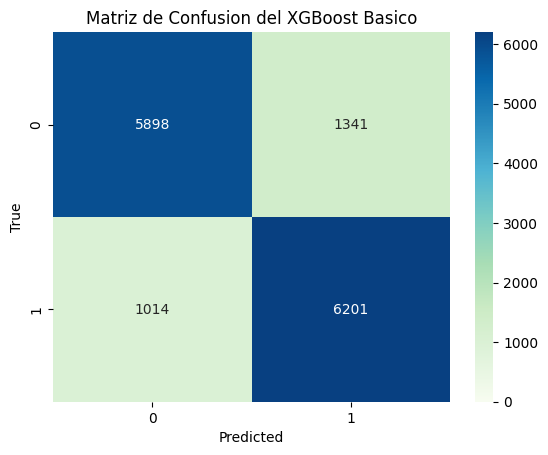

In [ ]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusion del XGBoost Basico')

print(classification_report(y_test, y_pred))
plt.show()

Para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8370693233706933
Recall: 0.8594594594594595
Precision: 0.8221957040572793
f1 score: 0.8404147184387071


### Randomized Search CV

Realizamos KFOLD CV Random Search para buscar los mejores hiperparametros del modelo con el siguiente codigo.

Como es un random search que devuelve distintos valores cada vez que se corre, y ademas tarda mucho tiempo, lo dejamos en formato texto. Si se desea correr el random, basta con copiar el codigo de abajo en un bloque de codigo y correrlo.

```
#Cantidad de combinaciones que quiero probar
n=10

#Conjunto de parámetros que quiero usar
params_grid = {'xgbclassifier__n_estimators': np.arange(40, 130),
               'xgbclassifier__max_leaves': np.arange(0, 30),
               'xgbclassifier__gamma': np.linspace(0.0, 10, 50),
               'xgbclassifier__reg_alpha': np.linspace(0.0, 5, 20),
               'xgbclassifier__reg_lambda': np.linspace(0.0, 5, 20),
               'xgbclassifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
xgbc = xgb.XGBClassifier(random_state=1, n_jobs = -1)
xgb_cv = make_pipeline(tfidf_vectorizer.set_params(norm='l2',min_df=3,lowercase=False), xgbc)

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=xgb_cv,
                            param_distributions = params_grid,
                            scoring=scorer_fn,
                            cv=kfoldcv,
                            n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(X_train,y_train)

print("Mejores hiperparámetros:", randomcv.best_params_)
print("Y su puntuacion es:", randomcv.best_score_)
```


Ademas, si se quiere predecir el modelo con los hiperparametros obtenidos, se puede correr el siguiente codigo copiandolo en un bloque de codigo.

```
xgb_cv_best=randomcv.best_estimator_
y_pred = xgb_cv_best.predict(X_test)
```



Para terminar, si se quieren obtener las metricas del modelo obtenido dejamos el siguiente codigo para copiar a un bloque de codigo.

Recordemos que las categorías de *sentimiento* son:

*   0 = Negativo
*   1 = Positivo



```
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusion del XGBoost')

plt.show()
print("\n",classification_report(y_test, y_pred))
```



```
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))
```





Particularmente nosotros, obtuvimos los siguientes hiperparametros con el random search.

In [1]:
print("n_estimators: 128")
print("max_leaves: 27")
print("learning_rate: 0.2")
print("reg_lambda: 1.0526315789473684")
print("reg_alpha: 2.631578947368421")
print("gamma: 2.6530612244897958")

n_estimators: 128
max_leaves: 27
learning_rate: 0.2
reg_lambda: 1.0526315789473684
reg_alpha: 2.631578947368421
gamma: 2.6530612244897958


### Cross Validation


Entrenamos el modelo con los mejores hiperparametros que nosotros encontramos en el random search.

In [ ]:
tfidf_vectorizer.set_params(norm = 'l2', lowercase = False)
xgbc = xgb.XGBClassifier(random_state = 1,
                         n_estimators = 128,
                         max_leaves = 27,
                         learning_rate = 0.2,
                         reg_lambda = 1.0526315789473684,
                         reg_alpha = 2.631578947368421,
                         gamma = 2.6530612244897958)

xgbc_micv = make_pipeline(tfidf_vectorizer, xgbc)

modelo = xgbc_micv.fit(X = X_train, y = y_train)
y_pred = modelo.predict(X_test)

resultados = pd.DataFrame(zip(y_test, y_pred), columns = ['test' , 'pred'])
resultados.sample(10)

,test,pred
6134,0,1
5674,0,0
9650,1,1
14328,0,1
10793,1,1
4248,1,1
7942,0,0
8333,1,0
2756,1,1
13199,0,0


Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *sentimiento* son:

*   0 = Negativo
*   1 = Positivo

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      7239
           1       0.83      0.86      0.84      7215

    accuracy                           0.84     14454
   macro avg       0.84      0.84      0.84     14454
weighted avg       0.84      0.84      0.84     14454



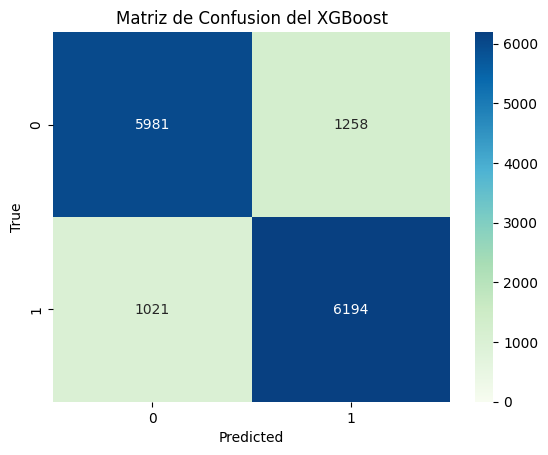

In [ ]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusion del XGBoost Optimizado')

print(classification_report(y_test, y_pred))
plt.show()

Para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8423273834232738
Recall: 0.8584892584892585
Precision: 0.8311862587224906
f1 score: 0.8446171677916411


## Kaggle Test

Ahora buscamos las predicciones del modelo con los datos del test de kaggle.

In [ ]:
y_pred_kaggle = modelo.predict(kaggle_test['review_es'])

En caso de haber ejecutado el codigo del random search que dejamos arriba, se pueden buscar las predicciones con el siguiente codigo:

```
y_pred_kaggle = xgb_cv_best.predict(kaggle_test['review_es'])
```


Exportamos el CSV de las predicciones obtenidas para subirlo a Kaggle.

In [ ]:
submit = pd.DataFrame(zip(kaggle_test['ID'], y_pred_kaggle), columns = ['ID' , 'sentimiento'])
submit['sentimiento'].replace(to_replace = {0 : 'negativo', 1 : 'positivo'}, inplace = True)

Y realizamos un grafico para visualizar las predicciones del modelo. Podemos observar que modelo predice mayoria de positivos.

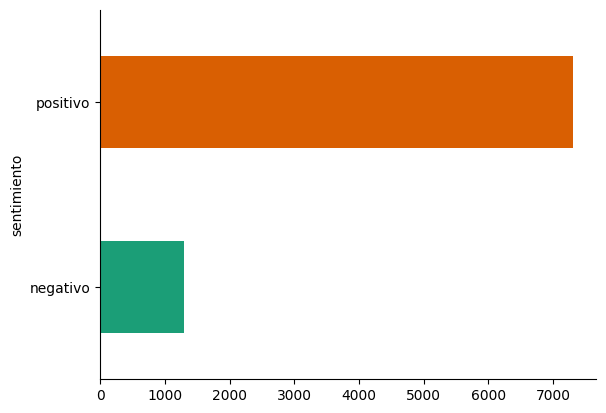

In [ ]:
submit.groupby('sentimiento').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
ruta_archivo = '/content/XGBC-27.csv'
submit.to_csv(ruta_archivo, index=False)

Para terminar con el modelo, lo guardamos en un archivo Joblib.

In [ ]:
joblib.dump(modelo, 'mejor_xgb.joblib')

['mejor_xgb.joblib']